In [2]:
!pip install wfdb


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os

base_path = "c:/Users/neham/Downloads/arryhthmia.serious/mit-bih-arrhythmia-database-1.0.0"

print("Folder exists:", os.path.exists(base_path))
print("Files inside folder:")
print(os.listdir(base_path)[:20])  # show first 20 files




Folder exists: True
Files inside folder:
['mit-bih-arrhythmia-database-1.0.0']


In [7]:
base_path = (
    "c:/Users/neham/Downloads/arryhthmia.serious/"
    "mit-bih-arrhythmia-database-1.0.0/"
    "mit-bih-arrhythmia-database-1.0.0"
)
import wfdb
import matplotlib.pyplot as plt
import os

record = wfdb.rdrecord(os.path.join(base_path, "100"))
annotation = wfdb.rdann(os.path.join(base_path, "100"), 'atr')

print("Signal shape:", record.p_signal.shape)
print("Sampling frequency:", record.fs)


Signal shape: (650000, 2)
Sampling frequency: 360


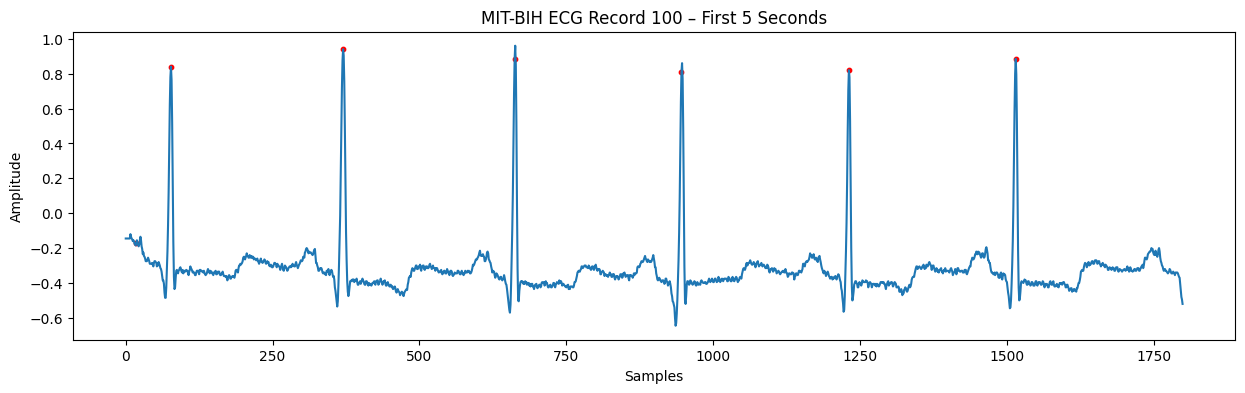

In [8]:
plt.figure(figsize=(15,4))

samples = int(5 * record.fs)
plt.plot(record.p_signal[:samples, 0])

r_peaks = annotation.sample[annotation.sample < samples]
plt.scatter(r_peaks, record.p_signal[r_peaks, 0], color='red', s=10)

plt.title("MIT-BIH ECG Record 100 – First 5 Seconds")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


In [9]:
import numpy as np

fs = record.fs
signal = record.p_signal[:, 0]   # use lead 1
r_peaks = annotation.sample

pre = int(0.2 * fs)    # 72
post = int(0.4 * fs)   # 144

beats = []
beat_labels = []

for i, r in enumerate(r_peaks):
    if r - pre >= 0 and r + post < len(signal):
        beat = signal[r - pre : r + post]
        beats.append(beat)
        beat_labels.append(annotation.symbol[i])

beats = np.array(beats)

print("Total beats extracted:", beats.shape)


Total beats extracted: (2272, 216)


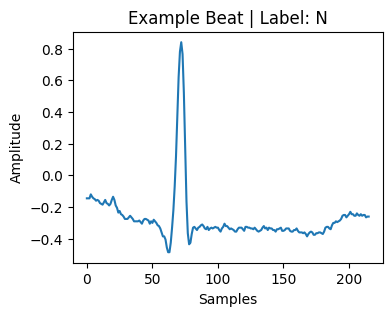

In [10]:
plt.figure(figsize=(4,3))
plt.plot(beats[0])
plt.title(f"Example Beat | Label: {beat_labels[0]}")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


In [11]:
aami_map = {
    'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    '/': 'Q', 'f': 'Q', 'Q': 'Q'
}


In [12]:
mapped_labels = []

for lbl in beat_labels:
    if lbl in aami_map:
        mapped_labels.append(aami_map[lbl])
    else:
        mapped_labels.append('Q')

mapped_labels = np.array(mapped_labels)

# Check distribution
import collections
print(collections.Counter(mapped_labels))


Counter({np.str_('N'): 2238, np.str_('S'): 33, np.str_('V'): 1})


In [14]:
import os

records = [f.replace('.hea', '') 
           for f in os.listdir(base_path) 
           if f.endswith('.hea')]

print("Total records:", len(records))
print(records[:10])


Total records: 48
['100', '101', '102', '103', '104', '105', '106', '107', '108', '109']


In [15]:
import wfdb
import numpy as np

all_beats = []
all_labels = []

for rec in records:
    record = wfdb.rdrecord(os.path.join(base_path, rec))
    ann = wfdb.rdann(os.path.join(base_path, rec), 'atr')

    signal = record.p_signal[:, 0]
    fs = record.fs

    pre = int(0.2 * fs)
    post = int(0.4 * fs)

    for i, r in enumerate(ann.sample):
        if r - pre >= 0 and r + post < len(signal):
            beat = signal[r - pre : r + post]
            label = ann.symbol[i]

            all_beats.append(beat)
            all_labels.append(label)

all_beats = np.array(all_beats)

print("Total beats extracted:", all_beats.shape)


Total beats extracted: (112575, 216)


In [16]:
aami_map = {
    'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    '/': 'Q', 'f': 'Q', 'Q': 'Q'
}

mapped_labels = []
for lbl in all_labels:
    mapped_labels.append(aami_map.get(lbl, 'Q'))


In [17]:
from collections import Counter
print(Counter(mapped_labels))


Counter({'N': 90600, 'Q': 11157, 'V': 7235, 'S': 2781, 'F': 802})


In [18]:
import random

random.seed(42)

unique_records = records.copy()
random.shuffle(unique_records)

split_idx = int(0.7 * len(unique_records))
train_records = unique_records[:split_idx]
test_records = unique_records[split_idx:]

print("Train records:", train_records)
print("Test records:", test_records)


Train records: ['208', '200', '201', '111', '123', '109', '209', '221', '113', '103', '215', '104', '230', '203', '112', '213', '207', '223', '119', '210', '233', '212', '217', '202', '122', '124', '234', '231', '100', '121', '117', '228', '114']
Test records: ['220', '232', '102', '205', '219', '105', '214', '106', '108', '115', '116', '118', '101', '107', '222']


In [19]:
X_train, y_train = [], []
X_test, y_test = [], []

for rec in records:
    record = wfdb.rdrecord(os.path.join(base_path, rec))
    ann = wfdb.rdann(os.path.join(base_path, rec), 'atr')

    signal = record.p_signal[:, 0]
    fs = record.fs

    pre = int(0.2 * fs)
    post = int(0.4 * fs)

    for i, r in enumerate(ann.sample):
        if r - pre >= 0 and r + post < len(signal):
            beat = signal[r - pre : r + post]
            label = aami_map.get(ann.symbol[i], 'Q')

            if rec in train_records:
                X_train.append(beat)
                y_train.append(label)
            else:
                X_test.append(beat)
                y_test.append(label)

import numpy as np
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Train beats:", X_train.shape)
print("Test beats:", X_test.shape)


Train beats: (79292, 216)
Test beats: (33283, 216)


In [20]:
train_mean = X_train.mean()
train_std = X_train.std()

X_train_norm = (X_train - train_mean) / train_std
X_test_norm  = (X_test  - train_mean) / train_std


In [21]:
label_map = {'N':0, 'S':1, 'V':2, 'F':3, 'Q':4}

y_train_enc = np.array([label_map[l] for l in y_train])
y_test_enc  = np.array([label_map[l] for l in y_test])


In [22]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train_enc)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_enc
)

class_weights = dict(zip(classes, class_weights))
print(class_weights)


{np.int64(0): np.float64(0.24332402491791205), np.int64(1): np.float64(16.14908350305499), np.int64(2): np.float64(2.609147745969069), np.int64(3): np.float64(20.150444726810672), np.int64(4): np.float64(2.528847073831925)}


In [23]:
# Add channel dimension
X_train_cnn = X_train_norm[..., np.newaxis]
X_test_cnn  = X_test_norm[..., np.newaxis]

print(X_train_cnn.shape)
print(X_test_cnn.shape)


(79292, 216, 1)
(33283, 216, 1)


In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D,
    GlobalAveragePooling1D, Dense, Dropout
)

inputs = Input(shape=(216, 1))

x = Conv1D(32, kernel_size=5, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(64, kernel_size=5, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)

# IMPORTANT for Grad-CAM
x = GlobalAveragePooling1D()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(5, activation='softmax')(x)

model = Model(inputs, outputs)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 216, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 216, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 108, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 108, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 54, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,781 (171.02 KB)

 Trainable params: 43,781 (171.02 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_test_cnn, y_test_enc),
    epochs=25,
    batch_size=256,
    class_weight=class_weights
)


Epoch 1/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2978 - loss: 1.4231 - val_accuracy: 0.3578 - val_loss: 1.2735
Epoch 2/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.3656 - loss: 1.1472 - val_accuracy: 0.4326 - val_loss: 1.1281
Epoch 3/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.4471 - loss: 0.9706 - val_accuracy: 0.3844 - val_loss: 1.2098
Epoch 4/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5011 - loss: 0.8849 - val_accuracy: 0.4919 - val_loss: 1.0523
Epoch 5/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5549 - loss: 0.8141 - val_accuracy: 0.5683 - val_loss: 1.0302
Epoch 6/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6056 - loss: 0.7633 - val_accuracy: 0.5472 - val_loss: 0.9840
Epoch 7/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6575 - loss: 0.7360 - val_accuracy: 0.4594 - val_loss: 1.2919
Epoch 8/25
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6761 - loss: 0.6984 - val_ac

In [27]:
# Remove Q class
keep_train = y_train != 'Q'
keep_test  = y_test  != 'Q'

X_train_f = X_train_norm[keep_train]
y_train_f = y_train[keep_train]

X_test_f  = X_test_norm[keep_test]
y_test_f  = y_test[keep_test]


In [28]:
label_map_4 = {'N':0, 'S':1, 'V':2, 'F':3}

y_train_enc = np.array([label_map_4[l] for l in y_train_f])
y_test_enc  = np.array([label_map_4[l] for l in y_test_f])


In [29]:

from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train_enc)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_enc
)

class_weights = dict(zip(classes, class_weights))
print(class_weights)


{np.int64(0): np.float64(0.28010019332862796), np.int64(1): np.float64(18.58986761710794), np.int64(2): np.float64(3.0034962158604803), np.int64(3): np.float64(23.19599745870394)}


In [30]:
X_train_cnn = X_train_f[..., np.newaxis]
X_test_cnn  = X_test_f[..., np.newaxis]

print(X_train_cnn.shape)
print(X_test_cnn.shape)


(73021, 216, 1)
(28397, 216, 1)


In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D,
    GlobalAveragePooling1D, Dense,
    Dropout, BatchNormalization, Activation
)

inputs = Input(shape=(216, 1))

x = Conv1D(32, 5, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(64, 5, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(128, 3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Grad-CAM friendly
x = GlobalAveragePooling1D()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(4, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 216, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 216, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 216, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 216, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 108, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 108, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 108, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 108, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 54, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 54, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,612 (174.27 KB)

 Trainable params: 44,164 (172.52 KB)

 Non-trainable params: 448 (1.75 KB)

In [32]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [34]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_test_cnn, y_test_enc),
    epochs=50,              # upper limit
    batch_size=256,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5668 - loss: 0.7302 - val_accuracy: 0.4227 - val_loss: 1.0505
Epoch 2/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.6435 - loss: 0.6479 - val_accuracy: 0.3632 - val_loss: 1.0459
Epoch 3/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.6898 - loss: 0.6055 - val_accuracy: 0.5275 - val_loss: 0.9886
Epoch 4/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.7130 - loss: 0.5614 - val_accuracy: 0.4960 - val_loss: 1.0073
Epoch 5/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.7518 - loss: 0.5516 - val_accuracy: 0.6536 - val_loss: 0.8136
Epoch 6/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.7593 - loss: 0.5261 - val_accuracy: 0.5077 - val_loss: 0.9722
Epoch 7/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.7745 - loss: 0.4949 - val_accuracy: 0.5373 - val_loss: 1.0358
Epoch 8/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.7921 - loss: 0.4916 - v

In [36]:
import numpy as np

y_pred = model.predict(X_test_cnn).argmax(axis=1)



888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [37]:
from sklearn.metrics import f1_score

print("Macro F1:", f1_score(y_test_enc, y_pred, average='macro'))


Macro F1: 0.32817580514336164


In [38]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test_enc,
    y_pred,
    target_names=['N', 'S', 'V', 'F']
))


              precision    recall  f1-score   support

           N       0.90      0.70      0.79     25426
           S       0.02      0.04      0.02      1799
           V       0.40      0.68      0.50      1157
           F       0.00      0.07      0.00        15

    accuracy                           0.65     28397
   macro avg       0.33      0.37      0.33     28397
weighted avg       0.83      0.65      0.73     28397



In [40]:
from tensorflow.keras.models import Model

feature_model = Model(
    inputs=model.input,
    outputs=model.get_layer('global_average_pooling1d_1').output
)

X_train_feat = feature_model.predict(X_train_cnn, batch_size=512)
X_test_feat  = feature_model.predict(X_test_cnn, batch_size=512)

print(X_train_feat.shape)
print(X_test_feat.shape)



143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
(73021, 128)
(28397, 128)


In [41]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Before SMOTE:", Counter(y_train_enc))

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_feat, y_train_enc)

print("After SMOTE:", Counter(y_train_sm))


Before SMOTE: Counter({np.int64(0): 65174, np.int64(2): 6078, np.int64(1): 982, np.int64(3): 787})
After SMOTE: Counter({np.int64(0): 65174, np.int64(1): 65174, np.int64(2): 65174, np.int64(3): 65174})


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

num_classes = len(set(y_train_enc))  # should be 4 (N,S,V,F)

clf = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_sm.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

clf.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

clf.summary()



c:\Users\neham\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,028 (97.77 KB)

 Trainable params: 25,028 (97.77 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
history = clf.fit(
    X_train_sm, y_train_sm,
    validation_data=(X_test_feat, y_test_enc),
    epochs=30,
    batch_size=256
)


Epoch 1/30
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8307 - loss: 0.4337 - val_accuracy: 0.5286 - val_loss: 1.1576
Epoch 2/30
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8774 - loss: 0.3132 - val_accuracy: 0.5645 - val_loss: 1.0738
Epoch 3/30
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8894 - loss: 0.2787 - val_accuracy: 0.5311 - val_loss: 1.1587
Epoch 4/30
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8979 - loss: 0.2573 - val_accuracy: 0.5994 - val_loss: 0.9482
Epoch 5/30
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9038 - loss: 0.2432 - val_accuracy: 0.5722 - val_loss: 1.0027
Epoch 6/30
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9083 - loss: 0.2345 - val_accuracy: 0.5520 - val_loss: 1.1520
Epoch 7/30
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9117 - loss: 0.2244 - val_accuracy: 0.5343 - val_loss: 1.2484
Epoch 8/30
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9143 - loss: 0.2194 - 

In [45]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

y_pred_sm = clf.predict(X_test_feat).argmax(axis=1)

print(classification_report(
    y_test_enc,
    y_pred_sm,
    target_names=['N','S','V','F']
))

print("Macro F1:", f1_score(y_test_enc, y_pred_sm, average='macro'))


888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step
              precision    recall  f1-score   support

           N       0.90      0.55      0.68     25426
           S       0.03      0.16      0.05      1799
           V       0.33      0.85      0.47      1157
           F       0.00      0.00      0.00        15

    accuracy                           0.54     28397
   macro avg       0.32      0.39      0.30     28397
weighted avg       0.82      0.54      0.63     28397

Macro F1: 0.3022111025977485


In [46]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_enc, y_pred_sm)
print("Test Accuracy:", accuracy)


Test Accuracy: 0.5359721097299011


In [47]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_enc, y_pred_sm)
print(cm)


[[13948  8427  1996  1055]
 [ 1434   290    20    55]
 [  113    31   982    31]
 [    2     9     4     0]]


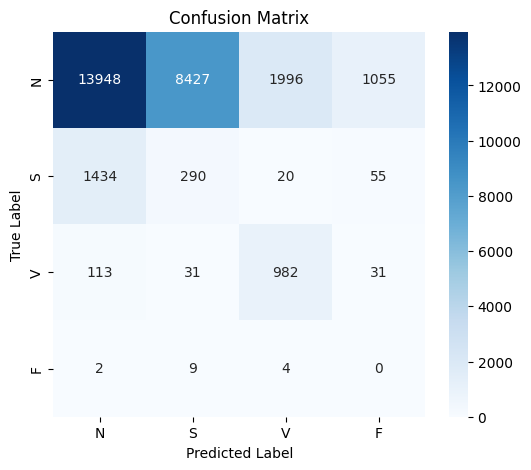

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

class_names = ['N', 'S', 'V', 'F']  # adjust if 3-class

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [49]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)


In [50]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

y_pred_sm = clf.predict(X_test_feat).argmax(axis=1)

print("Accuracy:", accuracy_score(y_test_enc, y_pred_sm))
print("Macro F1:", f1_score(y_test_enc, y_pred_sm, average='macro'))

print(classification_report(
    y_test_enc,
    y_pred_sm,
    target_names=['N','S','V','F']
))


888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step
Accuracy: 0.5359721097299011
Macro F1: 0.3022111025977485
              precision    recall  f1-score   support

           N       0.90      0.55      0.68     25426
           S       0.03      0.16      0.05      1799
           V       0.33      0.85      0.47      1157
           F       0.00      0.00      0.00        15

    accuracy                           0.54     28397
   macro avg       0.32      0.39      0.30     28397
weighted avg       0.82      0.54      0.63     28397



In [51]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D,
    BatchNormalization, Activation,
    Bidirectional, LSTM,
    Dense, Dropout
)

inputs = Input(shape=(216, 1))

# ---------- CNN BLOCK ----------
x = Conv1D(32, 5, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(64, 5, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(128, 3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# ---------- LSTM BLOCK ----------
x = Bidirectional(LSTM(64, return_sequences=False))(x)

# ---------- CLASSIFIER ----------
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(4, activation='softmax')(x)  # 4 classes: N,S,V,F

model = Model(inputs, outputs)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 216, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 216, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 216, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 216, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 108, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 108, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 108, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 108, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 54, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 54, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,428 (560.27 KB)

 Trainable params: 142,980 (558.52 KB)

 Non-trainable params: 448 (1.75 KB)

In [52]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [54]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',   # 👈 key change
    mode='max',
    patience=6,               # allow exploration
    restore_best_weights=True,
    verbose=1
)


history = model.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_test_cnn, y_test_enc),
    epochs=30,                # allow up to 30
    batch_size=128,
    class_weight=class_weights,
    callbacks=[early_stop]
)



Epoch 1/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - accuracy: 0.8378 - loss: 0.3881 - val_accuracy: 0.5624 - val_loss: 1.0307
Epoch 2/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - accuracy: 0.8570 - loss: 0.3324 - val_accuracy: 0.5793 - val_loss: 0.8616
Epoch 3/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 54s 94ms/step - accuracy: 0.8750 - loss: 0.2978 - val_accuracy: 0.5291 - val_loss: 1.0824
Epoch 4/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - accuracy: 0.8728 - loss: 0.2843 - val_accuracy: 0.7089 - val_loss: 0.7479
Epoch 5/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 51s 90ms/step - accuracy: 0.8791 - loss: 0.2701 - val_accuracy: 0.6661 - val_loss: 0.9977
Epoch 6/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 83s 91ms/step - accuracy: 0.8897 - loss: 0.2411 - val_accuracy: 0.6488 - val_loss: 0.8734
Epoch 7/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 106s 186ms/step - accuracy: 0.8967 - loss: 0.2273 - val_accuracy: 0.5318 - val_loss: 1.0381
Epoch 8/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 88s 154ms/step - accuracy: 0.8979 - loss: 0.2210

In [55]:
import numpy as np

# Predict class probabilities
y_pred_prob = model.predict(X_test_cnn)

# Convert to class labels
y_pred = np.argmax(y_pred_prob, axis=1)


888/888 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step


In [56]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test_enc, y_pred)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.7089481283234145


In [57]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(y_test_enc, y_pred, average='macro')
print("Macro F1:", macro_f1)


Macro F1: 0.3958370550022843


In [58]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test_enc,
    y_pred,
    target_names=['N', 'S', 'V', 'F']
))


              precision    recall  f1-score   support

           N       0.94      0.73      0.82     25426
           S       0.10      0.36      0.16      1799
           V       0.46      0.82      0.59      1157
           F       0.01      0.07      0.01        15

    accuracy                           0.71     28397
   macro avg       0.38      0.49      0.40     28397
weighted avg       0.86      0.71      0.77     28397



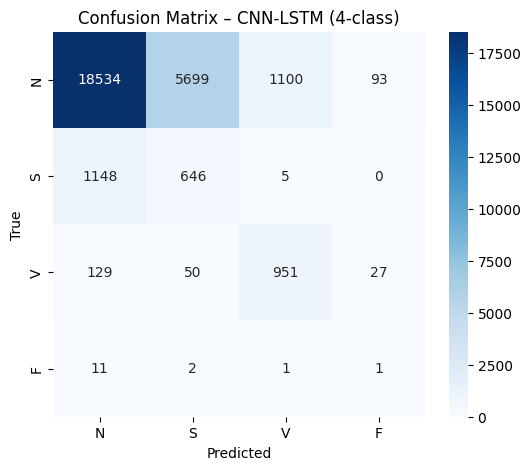

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_enc, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['N','S','V','F'],
    yticklabels=['N','S','V','F']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – CNN-LSTM (4-class)")
plt.show()


In [60]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def grad_cam_1d(model, signal, class_index, conv_layer_name):
    """
    signal: shape (216, 1)
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(signal)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=1)

    conv_outputs = conv_outputs[0]
    pooled_grads = pooled_grads[0]

    cam = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    cam = np.maximum(cam, 0)
    cam = cam / (np.max(cam) + 1e-8)

    cam = np.interp(
        np.linspace(0, len(cam), num=216),
        np.arange(len(cam)),
        cam
    )

    return cam


In [61]:
idx = 10   # change index to explore
signal = X_test_cnn[idx:idx+1]   # shape (1,216,1)
true_label = y_test_enc[idx]


In [62]:
pred = model.predict(signal)
pred_class = np.argmax(pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [63]:
cam = grad_cam_1d(
    model,
    signal,
    class_index=pred_class,
    conv_layer_name='conv1d_8'
)


c:\Users\neham\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_32']]
Received: inputs=Tensor(shape=(1, 216, 1))
  warnings.warn(msg)


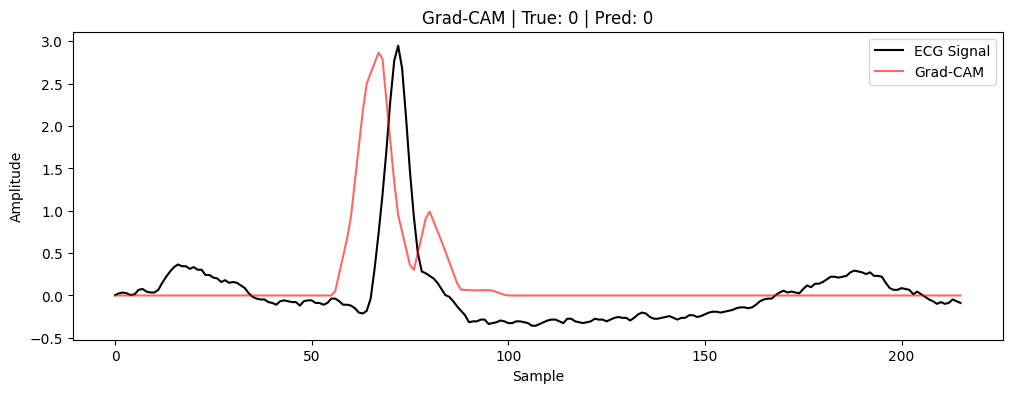

In [64]:
plt.figure(figsize=(12,4))

plt.plot(signal[0,:,0], label='ECG Signal', color='black')
plt.plot(cam * np.max(signal[0,:,0]), 
         label='Grad-CAM', 
         color='red', alpha=0.6)

plt.title(
    f"Grad-CAM | True: {true_label} | Pred: {pred_class}"
)
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [65]:
import numpy as np

def normalize_cam(cam):
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    return cam


In [66]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_gradcam_colored(ecg, cam, true_label, pred_label):
    cam = normalize_cam(cam)
    x = np.arange(len(ecg))

    plt.figure(figsize=(14,4))

    # Plot ECG
    plt.plot(x, ecg, color='black', linewidth=1.5, label='ECG Signal')

    # Colored Grad-CAM overlay
    cmap = cm.jet
    for i in range(len(ecg)-1):
        plt.fill_between(
            x[i:i+2],
            ecg.min(),
            ecg.max(),
            color=cmap(cam[i]),
            alpha=cam[i] * 0.6
        )

    plt.colorbar(
        cm.ScalarMappable(cmap=cmap),
        label="Grad-CAM Importance"
    )

    plt.title(f"Grad-CAM ECG | True: {true_label} | Pred: {pred_label}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [68]:
idx = 0   # you can change this later



In [69]:
sample_ecg = X_test[idx].squeeze()   # shape → (216,)


In [71]:
cnn_lstm_model = model  # do this ONLY if 'model' printed functional_4 last


In [72]:
cnn_lstm_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 216, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 216, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 216, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 216, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 108, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 108, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 108, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 108, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 54, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 54, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,390 (1.64 MB)

 Trainable params: 142,980 (558.52 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 285,962 (1.09 MB)

In [73]:
idx = 0  # change this to visualize other beats

sample_ecg = X_test[idx].reshape(1, 216, 1)
y_true = y_test_enc[idx]


In [74]:
y_pred_probs = cnn_lstm_model(sample_ecg, training=False).numpy()
y_pred = np.argmax(y_pred_probs)


In [75]:
last_conv_layer = cnn_lstm_model.get_layer("conv1d_8")

grad_model = tf.keras.models.Model(
    inputs=cnn_lstm_model.input,
    outputs=[last_conv_layer.output, cnn_lstm_model.output]
)

with tf.GradientTape() as tape:
    conv_out, preds = grad_model(sample_ecg)
    loss = preds[:, y_pred]

grads = tape.gradient(loss, conv_out)
weights = tf.reduce_mean(grads, axis=1)

cam = tf.reduce_sum(weights[:, None, :] * conv_out, axis=-1)
gradcam_1d = cam.numpy().squeeze()


In [76]:
from scipy.signal import resample

gradcam_1d = resample(gradcam_1d, 216)
gradcam_1d = np.maximum(gradcam_1d, 0)
gradcam_1d = gradcam_1d / (gradcam_1d.max() + 1e-8)


In [77]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_gradcam_colored(ecg, cam, true_label, pred_label):
    x = np.arange(len(ecg))
    colors = cam  # intensity controls color

    plt.figure(figsize=(14, 4))

    # Plot ECG as background
    plt.plot(x, ecg, color="black", linewidth=2, zorder=1)

    # Color overlay
    plt.scatter(
        x, ecg,
        c=colors,
        cmap="jet",
        s=15,
        alpha=0.8,
        zorder=2
    )

    plt.colorbar(label="Grad-CAM Importance")
    plt.title(f"Grad-CAM | True: {true_label} | Pred: {pred_label}")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()


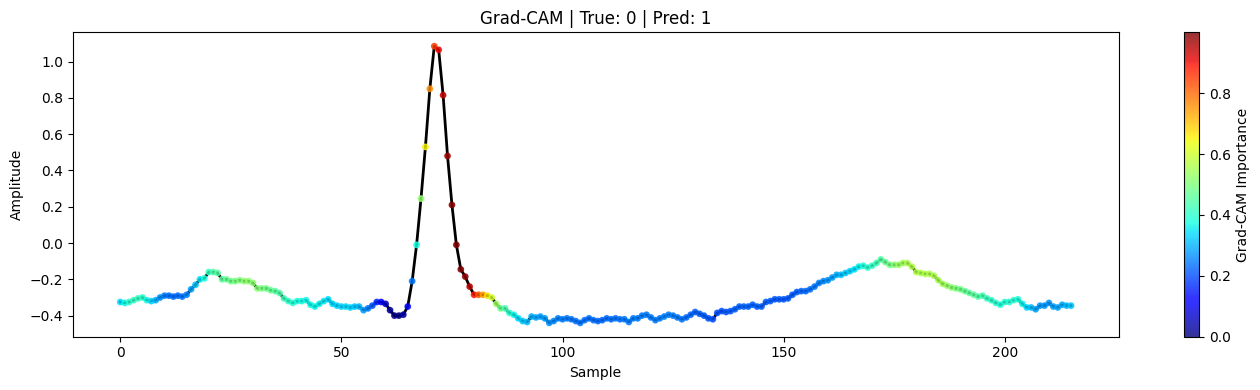

In [78]:
plot_gradcam_colored(
    ecg=sample_ecg.squeeze(),
    cam=gradcam_1d,
    true_label=y_true,
    pred_label=y_pred
)


In [79]:
class_names = {
    0: "Normal Beat (N)",
    1: "Supraventricular Ectopic Beat (S)",
    2: "Ventricular Ectopic Beat (V)",
    3: "Fusion Beat (F)"
}


In [80]:
severity_base = {
    0: 10,   # Normal
    1: 40,   # Supraventricular
    2: 70,   # Ventricular (more severe)
    3: 60    # Fusion
}


In [81]:
confidence = float(y_pred_probs[0, y_pred])  # model confidence
severity_score = int(severity_base[y_pred] * confidence)
severity_score = min(severity_score, 100)


In [82]:
def plot_gradcam_colored_with_prediction(ecg, cam, y_true, y_pred, y_pred_probs):
    x = np.arange(len(ecg))
    colors = cam

    pred_label_name = class_names[y_pred]
    true_label_name = class_names[y_true]

    confidence = float(y_pred_probs[0, y_pred])
    severity = int(severity_base[y_pred] * confidence)
    severity = min(severity, 100)

    plt.figure(figsize=(15, 4))

    # ECG waveform
    plt.plot(x, ecg, color="black", linewidth=2, zorder=1)

    # Grad-CAM overlay
    sc = plt.scatter(
        x, ecg,
        c=colors,
        cmap="jet",
        s=15,
        alpha=0.8,
        zorder=2
    )

    plt.colorbar(sc, label="Grad-CAM Importance")

    title = (
        f"Prediction: {pred_label_name} | "
        f"Confidence: {confidence:.2f} | "
        f"Severity Score: {severity}/100\n"
        f"True Label: {true_label_name}"
    )

    plt.title(title, fontsize=11)
    plt.xlabel("Sample Index")
    plt.ylabel("ECG Amplitude")
    plt.tight_layout()
    plt.show()


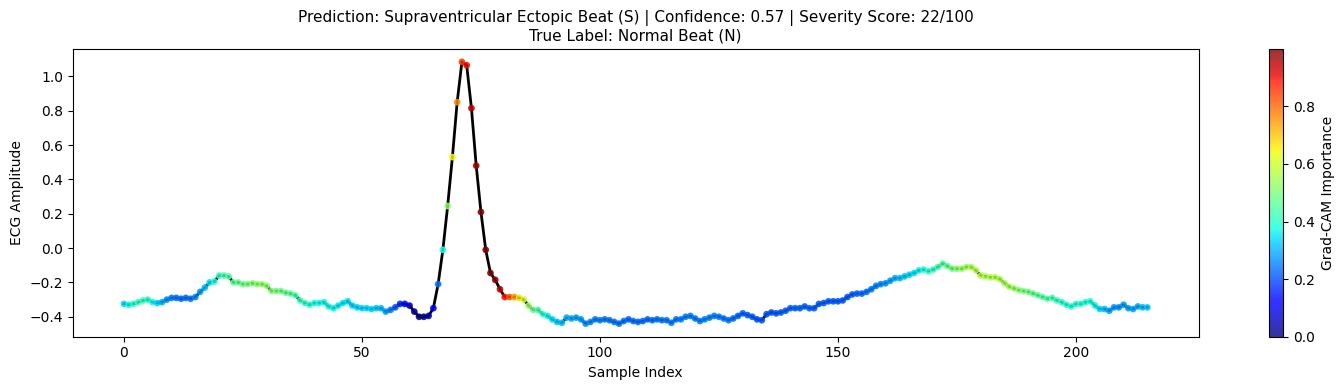

In [83]:
plot_gradcam_colored_with_prediction(
    ecg=sample_ecg.squeeze(),
    cam=gradcam_1d,
    y_true=y_true,
    y_pred=y_pred,
    y_pred_probs=y_pred_probs
)


In [84]:
cnn_lstm_model.save("arrhythmia_cnn_lstm_model.h5")
print("Model saved successfully")


Model saved successfully


In [85]:
import os

# Target folder
save_dir = r"C:/Users/neham/Downloads/arryhthmia.serious"
os.makedirs(save_dir, exist_ok=True)

# Full path
model_path = os.path.join(save_dir, "arrhythmia_cnn_lstm_model.h5")

# Save model
model.save(model_path)

print("✅ Model saved at:", model_path)


✅ Model saved at: C:/Users/neham/Downloads/arryhthmia.serious\arrhythmia_cnn_lstm_model.h5


In [86]:
import os
print(os.path.exists(model_path))


True


In [87]:
import pandas as pd
import numpy as np

# X_test: (N, 216), y_test: (N,)
sample_idx = np.random.choice(len(X_test), 50, replace=False)

df_test = pd.DataFrame(
    np.hstack([X_test[sample_idx], y_test[sample_idx].reshape(-1,1)])
)

df_test.to_csv("ecg_test_sample.csv", index=False, header=False)


In [88]:
import os
print(os.getcwd())


c:\Users\neham\AppData\Local\Programs\Microsoft VS Code


In [89]:
import os

save_path = r"C:/Users/neham/Downloads/arryhthmia.serious/ecg_test_sample.csv"

# make sure folder exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# save CSV (no header, no index – Streamlit ready)
df_test.to_csv(save_path, index=False, header=False)

print("Saved at:", save_path)


Saved at: C:/Users/neham/Downloads/arryhthmia.serious/ecg_test_sample.csv


In [90]:
import os
print(os.path.exists(r"C:/Users/neham/Downloads/arryhthmia.serious/ecg_test_sample.csv"))


True
